# Lecture 13 - Twitter Data Collection
In this notebook we will learn how to collect Twitter data using the Twitter API. 

<ol type = 1>
<li> Keyword Tweets</li>
    <ol type = a>
        <li> Collect tweets containing keywords</li>
        <li> Collect screen names from user IDs</li>
    </ol>
    
<li> User Profiles</li>
    <ol type = a>
        <li> Collect user profiles</li>
    </ol>
 
<li>User Tweets</li>
    <ol type = a>
        <li>Collect the tweets posted by specific users</li>
    </ol>

<li>User Followings</li>
    <ol type = a>
        <li>Collect the followings for a set of users</li>
    </ol>

<li>Build Networks</li>
    <ol type = a>
        <li> Follower Network </li>
            <ol type = a>
                <li>Build follower network from a database of user followings</li>
            </ol>
        <li> Interaction Network </li>
            <ol type = a>
                <li>Build ineration network from a database of keyword tweets</li>
            </ol>
        <li> Similarity Network </li>
            <ol type = a>
                <li>Build similarity network  from an interaction network (for community detection)</li>
            </ol>
    </ol>
    
    
This notebook will not work in Colab.  Please run it on your local machine.

# Clones, installs, and imports


## Clone GitHub Repository

You will have to clone the repository to your local machine before running this notebook.  This can be done from a terminal by typing `git clone https://github.com/zlisto/social_media_analytics.git`.

If you have already cloned this repository before, but want to update to the current version, from a terminal change directory to `social_media_analytics` and then type `git pull`.

## Install Requirements 

In [81]:
!pip install -r requirements.txt


You should consider upgrading via the 'c:\users\zlisto\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


## Bearer Token

After cloning or pulling the repository, they file `data/config.py` will be overwritten to a blank file.  You will need to edit the file by pasting in your Twitter API bearer token as follows: `BEARER0 = 'your bearer token here as a string'`.  This gives you access to the Twitter API.  You can access your bearer token here: https://developer.twitter.com/en/portal/dashboard


## Import Packages

The important import is from `scripts.api` where your bearer token is imported as the variable `BEARER0`.

In [1]:
%load_ext autoreload
%autoreload 2

from scripts.api import *

from scripts.create_graph import *
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

pd.set_option("display.max_colwidth", None)


# Collect Tweets by Keyword with the Twitter API

The code below allows you to collect tweets that contain a keyword, or one of many in a set of keywords.  The tweets will be saved to a database with filename `fname_db` in a table called `"keyword_tweets"`.  

The user inputs are as follows:

1. `fname_db` =  the database filename where you want to store the tweets.  Do not add the `".db"` suffix.

2. `target_total` = the total number of tweets you want to collect per keyword.

3. `keywords`  = a list of the words you want to search for.  Even if you have one keyword, it must still be in a list.

4. `start_date` = string of the earliest date of tweets you want.  Should be in `yyyy-mm-dd` format.

5. `end_date` = string of the latest date of tweets you want.  Should be in `yyyy-mm-dd` format.  WARNING:  If `end_date` is a future date, the code will not work.  Make sure not to go beyond today.

6. `retweets` = `True` if you want to collect retweets, otherwise `False` if you only want to get original tweets.

In [2]:
fname_db = f"data/lecture_13"  
target_total = 100  
keywords = ['vacccine','COVID'] 
start_date = '2022-02-01'   
end_date = '2022-02-06'
retweets = False

## Collect Tweets

The `for` loop will go through each keyword in `keywords` and collect up to `target_total` tweets per keyword.  The tweets will be saved to the database in `fname_db` in the table `keyword_tweets`.



In [3]:
#If you want a fresh table, delete the existing table.  Be careful, because this will erase your data.
#Uncomment the line below to delete the existing table.

#DB.delete(table_name='keyword_tweets', path=fname_db)  


[2022-03-08 02:02:40.158] [INFO] [api:delete:25] Deleting table keyword_tweets


In [4]:
for keyword in keywords:
    print(f"Getting tweets for {keyword}")
    df_keyword = History.fetch(keyword=keyword, start_date= start_date, end_date= end_date, 
                    target_total=target_total, retweets=retweets)       
    DB.write(table_name='keyword_tweets', path=fname_db, data=df_keyword)

    

Getting tweets for vacccine
[2022-03-08 02:02:48.025] [INFO] [api:fetch:212] Fetched 51 tweets
[2022-03-08 02:02:48.050] [INFO] [api:write:60] Writing 51 rows to table keyword_tweets
Getting tweets for COVID
[2022-03-08 02:02:49.722] [INFO] [api:fetch:212] Fetched 98 tweets
[2022-03-08 02:02:51.397] [INFO] [api:fetch:212] Fetched 98 tweets
[2022-03-08 02:02:51.434] [INFO] [api:write:60] Writing 196 rows to table keyword_tweets


## Check `"keyword_tweets"` Table

We will add some columns to the keyword tweets dataframe to make a nice time series plot.

In [6]:
df_keyword = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")

format = "%Y-%m-%d %H:%M:%S"
df_keyword ['created_at_datetime'] = pd.to_datetime(df_keyword ['created_at'],format=format).dt.tz_localize(None)
df_keyword .sort_values(by = 'created_at_datetime', inplace = True, ascending = True)
df_keyword ['tweet_indicator'] = np.ones(len(df_keyword ))
df_keyword ['rate_1D'] = df_keyword .rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']
df_keyword ['rate_7D'] = df_keyword .rolling('7D',on = 'created_at_datetime').sum()['tweet_indicator']/7




247 keyword tweets


In [7]:

print(f"Head:\n{df_keyword .created_at.head(n=3)}")
print(f"Tail:\n{df_keyword .created_at.tail(n=3)}")


Head:
50    2022-02-01T02:15:12.000Z
49    2022-02-01T02:26:40.000Z
48    2022-02-01T04:05:56.000Z
Name: created_at, dtype: object
Tail:
51    2022-02-05T23:59:59.000Z
52    2022-02-05T23:59:59.000Z
53    2022-02-05T23:59:59.000Z
Name: created_at, dtype: object


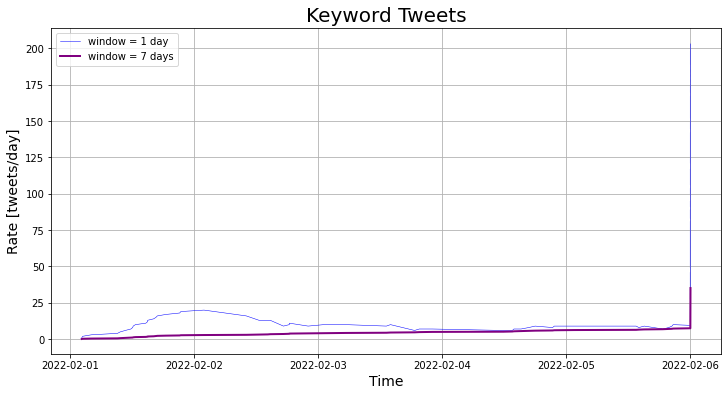

In [8]:

fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_keyword , x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .5,color = 'blue')
sns.lineplot(data = df_keyword , x = 'created_at_datetime',y = 'rate_7D',label = 'window = 7 days', linewidth = 2,color = 'purple')

plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"Keyword Tweets",fontsize = 20)

plt.legend()
plt.show()

## Collect Screen Names of Keyword Tweets

The Twitter API only gives the ID of a tweet author.  To get the screen name we have to run the code below.  This code collects the screen names for a list of author IDs, then saves the screen names along with the tweets in a new database. This is a slow query, so it is advisable to instead get a smaller set of author IDs you are interested in, and then collect their screen names.

The user inputs are as follows:

`authorids` = list of author IDs as strings.  You can obtain the entire list from the `keyword_tweets` table, or you can input your own list manually.

`fname_db` = name of database where you want to save the keyword tweets plus the screen names

In [9]:
fname_db = f"data/lecture_13"  #database filenmae

#load database of keyword_tweets into dataframe
df_keyword  = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")


247 keyword tweets


In [10]:
#get author IDs for keyword tweets table
authorids = df_keyword.author_id.unique().tolist()
print(f"userids has {len(authorids)} author ids")

userids has 241 author ids


In [11]:
#or create your own list of author IDs
authorids = ['187485612',
 '1002278761734328321',
 '1489362675889065985']

print(f"userids has {len(authorids)} author ids")

userids has 3 author ids


In [13]:
#for loop that looks up the screen name (called username here) for each user ID
usernames = {}
c=0
print(f"We are going to collect screen names for {len(authorids)} users")
for authorid in authorids:
    username = User.id_to_username(user_id = authorid, token=0) #collect user profiles using Twitter API in a dataframe
    usernames[authorid] = username
    c+=1
    if c%100 ==0:print(f"user {c}/{len(authorids)}")
print(f"Collected screen names for {c} users")

We are going to collect screen names for 3 users
Collected screen names for 3 users


In [14]:
#look at the screen names
usernames

{'187485612': 'Phaamsaam',
 '1002278761734328321': 'MatthewMcCrac18',
 '1489362675889065985': 'NSpippa'}

In [15]:
#add screen_name column to dataframe/database

col = []
for author_id in df_keyword.author_id:
    if author_id in usernames:
        col.append(usernames[author_id])
    else:
        col.append(np.NaN)
        
df_keyword['screen_name'] = col


In [20]:
df_keyword[['screen_name','text']].head()

,screen_name,text
0,Phaamsaam,"@DrThompson22 @SEzekwesili @DaddyFRZ @NafdacAgency @JoyceOnyemuwa It's so funny and annoying to note that @NafdacAgency simply relied blindly (or in collusion) with NCD statement of covid vacccine being ""safe and effective"" since none of the pharma released necessary data to verify those claims, pushed&amp; still pushing these killer vaccines"
1,MatthewMcCrac18,"@cashandcarrots @Mafia5000 @johnpilger @tatteredstones MICIMATT = militiary industrical-congressional-intelligence-media-academia-think tank complex. It's not just the media. When they are all on message with ""Russia!! Russia!! Russia!! and ""China!! China!! China!!"" and ""Vaccine!! Vaccine!! Vacccine!!"" look out!!"
2,NSpippa,@palmy2967 @MaryClareMacDo1 @cosminDZS @wpgpolice I will put my 53 year measle vacccine up against my 2 week covid vaccine anyday.
3,None,"@mattletiss7 Another pointless tweet again without knowing the facts, your clearly against the vacccine which is you’re choice but at least have the facts about the incidents before you’re pointless tweets"
4,None,@RichardBarrow We couldnt enter khaosan road tonight because our vaccination card is over than 3 months(2dose vacccine)They are forcing us to vaccine https://t.co/MZWOuiEtVh.Share this please


### Update `"keyword_tweets"` Table

In [17]:
#delete old table
DB.delete(table_name='keyword_tweets', path=fname_db)  

#save dataframe with screen names to table
DB.write(table_name='keyword_tweets', path=fname_db, data=df_keyword)  #Save profiles to database


[2022-03-08 02:04:16.404] [INFO] [api:delete:25] Deleting table keyword_tweets
[2022-03-08 02:04:16.415] [INFO] [api:write:60] Writing 247 rows to table keyword_tweets


### Check `"keyword_tweets"` Table 

We will load the keyword tweet table into a dataframe and look at the rows that have screen names.

In [18]:
df_keyword = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")

df_keyword.loc[df_keyword.screen_name.isna()==False,['screen_name','text']].head()

247 keyword tweets


,screen_name,text
0,Phaamsaam,"@DrThompson22 @SEzekwesili @DaddyFRZ @NafdacAgency @JoyceOnyemuwa It's so funny and annoying to note that @NafdacAgency simply relied blindly (or in collusion) with NCD statement of covid vacccine being ""safe and effective"" since none of the pharma released necessary data to verify those claims, pushed&amp; still pushing these killer vaccines"
1,MatthewMcCrac18,"@cashandcarrots @Mafia5000 @johnpilger @tatteredstones MICIMATT = militiary industrical-congressional-intelligence-media-academia-think tank complex. It's not just the media. When they are all on message with ""Russia!! Russia!! Russia!! and ""China!! China!! China!!"" and ""Vaccine!! Vaccine!! Vacccine!!"" look out!!"
2,NSpippa,@palmy2967 @MaryClareMacDo1 @cosminDZS @wpgpolice I will put my 53 year measle vacccine up against my 2 week covid vaccine anyday.


# Collect User Profiles

The code below allows you to collect Twitter profiles from specific users.  The tweets will be saved to a database with filename `fname_db` in a table called `"users"`.  

The user inputs are as follows:

1. `fname_db` = the database filename where you want to store the profiles.  Do not add the `".db"` suffix.

3. `screen_names`  = a list of the screen name you want profiles for.  Even if you have one screen name, it must still be in a list.





In [25]:
fname_db = "data/lecture_13"
screen_names =['Cristiano', 'BLACKPINK', 'KingJames']


In [28]:
#If you want a fresh table, delete the existing table.  Be careful, because this will erase your data.
#Uncomment the line below to delete the existing table.

#DB.delete(table_name='users', path=fname_db)

In [27]:
#collect user profiles
df_profiles = User.user_info(screen_names)  #collect user profiles using Twitter API in a dataframe

#write profiles to users table
DB.write(table_name='users', path=fname_db, data=df_profiles)  #Save profiles to database

#look at head of table
df_profiles.head()

[2022-03-08 02:05:27.301] [INFO] [api:write:60] Writing 3 rows to table users


,created_at,name,username,description,id,location,followers_count,following_count,listed_count,tweet_count
0,2010-06-14T19:09:20.000Z,Cristiano Ronaldo,Cristiano,This Privacy Policy addresses the collection and use of personal information - https://t.co/N9W2J34YdA,155659213,NaN,98041209,60,84507,3769
1,2020-06-19T05:32:29.000Z,BLACKPINKOFFICIAL,BLACKPINK,BLΛƆKPIИK,1273850774380883975,NaN,6023745,0,7111,489
2,2009-03-06T16:25:53.000Z,LeBron James,KingJames,EST. AKRON - ST.V/M Class of '03 https://t.co/TrZZrgR90t #IPROMISE,23083404,Amongst La Familia!,50971465,182,45545,8290


## Check `"users"` Table

In [29]:
df_profiles = DB.fetch(table_name='users', path=fname_db)  
df_profiles.head()

,created_at,name,screen_name,description,id,location,followers_count,following_count,listed_count,tweet_count
0,2010-06-14T19:09:20.000Z,Cristiano Ronaldo,Cristiano,This Privacy Policy addresses the collection and use of personal information - https://t.co/N9W2J34YdA,155659213,None,98041209,60,84507,3769
1,2020-06-19T05:32:29.000Z,BLACKPINKOFFICIAL,BLACKPINK,BLΛƆKPIИK,1273850774380883975,None,6023745,0,7111,489
2,2009-03-06T16:25:53.000Z,LeBron James,KingJames,EST. AKRON - ST.V/M Class of '03 https://t.co/TrZZrgR90t #IPROMISE,23083404,Amongst La Familia!,50971465,182,45545,8290


# Collect User Tweets

The code below allows you to collect tweets of specific users.  The tweets will be saved to a database with filename `fname_db` in a table called `"user_tweets"`.  

The user inputs are as follows:

1. `fname_db` = the database filename where you want to store the tweets.  Do not add the `".db"` suffix.

2. `max_results` = the total number of tweets you want to collect per user.

3. `screen_names`  = a list of screen names you want to search for.  Even if you have one screen name, it must still be in a list.

4. `start_date` = string of the earliest date of tweets you want.  Should be in `yyyy-mm-dd` format. (This doesn't seem to work for user tweets).

5. `end_date` = string of the latest date of tweets you want.  Should be in `yyyy-mm-dd` format.  (This doesn't seem to work for user tweets).



In [30]:
fname_db = "data/lecture_13"
screen_names =['Cristiano', 'BLACKPINK', 'KingJames']
max_results = 100
start_date ='2016-02-01'
end_date = '2025-03-29'


In [32]:
#If you want a fresh table, delete the existing table.  Be careful, because this will erase your data.
#Uncomment the line below to delete the existing table.


#DB.delete(table_name='user_tweets', path=fname_db)


In [33]:
for screen_name in screen_names: 
    print(f"Collecting tweets for {screen_name}")
    user_id =  User.user_info([screen_name]).id.values[0]
    df_ut = Tweet.fetch_user_tweets(user_id, start_date, end_date,max_results)
    
    #add in a screen_name column for convenience
    df_ut['screen_name']= screen_name
    
    #write dataframe to table
    DB.write(table_name='user_tweets', path=fname_db, data=df_ut)

[2022-03-08 02:05:51.579] [INFO] [api:fetch_user_tweets:279] Fetched 100 tweets
[2022-03-08 02:05:51.619] [INFO] [api:write:60] Writing 100 rows to table user_tweets
[2022-03-08 02:05:52.428] [INFO] [api:fetch_user_tweets:279] Fetched 100 tweets
[2022-03-08 02:05:52.470] [INFO] [api:write:60] Writing 100 rows to table user_tweets
[2022-03-08 02:05:53.198] [INFO] [api:fetch_user_tweets:279] Fetched 100 tweets
[2022-03-08 02:05:53.236] [INFO] [api:write:60] Writing 100 rows to table user_tweets


## Check `"user_tweets"` Table 

,created_at,screen_name,text
146,2021-10-29T23:01:54.000Z,BLACKPINK,"#BLACKPINK '불장난 (PLAYING WITH FIRE)' M/V HITS 700 MILLION VIEWS \n@Youtube\n \nBLINKs worldwide, thank you so much!\n\n'불장난 (PLAYING WITH FIRE)' M/V\n📽️ https://t.co/Xhb1NECV7n\n\n#블랙핑크 #PLAYINGWITHFIRE #불장난 #MV #700MILLION #YOUTUBE #YG https://t.co/QniLuSMftI"
124,2021-12-03T09:55:20.000Z,BLACKPINK,"RT @SpotifyKR: 2021년 함께할 때도, 홀로 설 때도\n완벽한 넷이자, 완벽한 솔로🖤\n@BLACKPINK\n전 세계 스트리밍 2,274,004,916+회\n\n#스포티파이_랩드_연말결산\n올해를 음악으로 정리해 봐!\n\n2021 대한민국 음악▶️…"
10,2022-01-26T14:10:09.000Z,Cristiano,Proud Dad ❤️🙏🏽 https://t.co/v8gw3KVyqM
263,2022-01-17T01:50:52.000Z,KingJames,#LakerNation I apologize and I promise we’ll be better! 👑💜💛


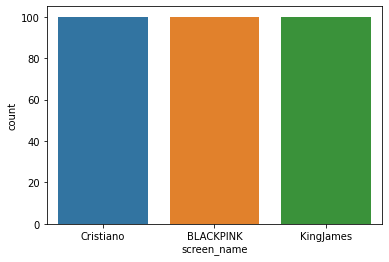

In [36]:
df_ut = DB.fetch(table_name='user_tweets', path=fname_db)

sns.countplot(data = df_ut, x = 'screen_name')
df_ut[['created_at','screen_name','text']].sample(n=4)

# Collect User Followings

This code will collect the followings for a group of users.  

The user inputs are as follows:

1. `fname_db` = the database filename where you want to store the followings.  Do not add the `".db"` suffix.


2. `screen_names`  = a list of screen names you want to collect followings for.  Even if you have one screen name, it must still be in a list.

3. `max_following` = the maximum number of following to get per user.  If this value is large, the code will take longer to run if you have users with a massive following count.



In [59]:
fname_db = "data/lecture_13"

screen_names =['POTUS', 'BarackObama', 'FLOTUS']
max_following = 5


In [61]:
#If you want a fresh table, delete the existing table.  Be careful, because this will erase your data.
#Uncomment the line below to delete the existing table.


#DB.delete(table_name='following', path = fname_db)

In [62]:
#This code queries the Twitter API for the followings.  It can be VERY slow
df_following = Follow.fetch(users=screen_names, target_total = max_following, token_number = 0, kind='following')
df_following.head()

POTUS          WHCOVIDResponse,WHCommsDir,AmbRice46,JOD46,WHCOS
BarackObama        VP,POTUS,DemRedistrict,Merone,HillaryClinton
FLOTUS         LaCasaBlanca,WhiteHouse,SecondGentleman,VP,POTUS
dtype: object

In [63]:
#write dataframe to table
DB.write(table_name='following', path=fname_db, data=df_following)

[2022-03-08 02:09:48.214] [INFO] [api:write:60] Writing 3 rows to table following


## Check `"following"` Table

In [64]:
df_following = DB.fetch(table_name='following', path=fname_db)
df_following.head()

,0,1
0,POTUS,"WHCOVIDResponse,WHCommsDir,AmbRice46,JOD46,WHCOS"
1,BarackObama,"VP,POTUS,DemRedistrict,Merone,HillaryClinton"
2,FLOTUS,"LaCasaBlanca,WhiteHouse,SecondGentleman,VP,POTUS"


# Build Networks

We will created networkx objects for different networks and save them as pickle files.

## Build Follower Network From Database

This code creates the networkx object for the follower network from the database.  

The user inputs are as follows:


1. `fname_db` = database filename where you stored the followings.  Do not add the `".db"` suffix.


2. `fname_following_network` = filename to save follower network to (should end in `".pickle"`)


In [65]:
fname_db = "data/lecture_13"
fname_following_network = "data/lecture_13_following_network.pickle"

In [66]:
df_following = DB.fetch(table_name='following', path=fname_db)

Gf = nx.DiGraph()
V = set(df_following[0].tolist())
for row in zip(df_following[0], df_following[1]):
    nb = row[1].split(",")
    node = row[0]
    Gf.add_node(node)
    for u in nb:
        if u in V:
            Gf.add_edge(u,node)

nx.write_gpickle(Gf,fname_following_network)

### Draw Following Network (If Not Too Big)

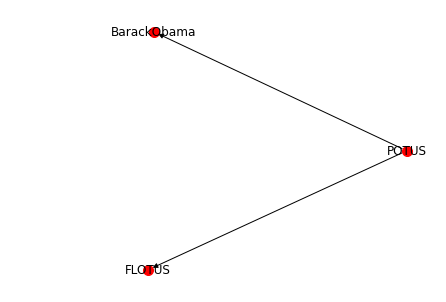

In [67]:
Gf = nx.read_gpickle(fname_following_network)

nv_max = 100  #max number of nodes to draw for
nv = Gf.number_of_nodes()
if nv<nv_max:
    pos = nx.kamada_kawai_layout(Gf.to_undirected())
    nx.draw(Gf,pos,node_size = 100, node_color = 'red', with_labels = True)
    
else: print(f"Network has {nv} nodes, which is more than {nv_max}")

## Build Interaction Network From Keyword Tweets

We can build an interaction network from the tweets in the `keyword_tweets` table using the function `interaction_network_from_tweets`.
The interaction network includes retweets, replies, and regular mentions of other users.  Our edge convention points to the person tweeting from the person being mentioned in the tweet. 

The user inputs are as follows:

1. `fname_db` = database filename where you stored the keyword tweets.  Do not add the `".db"` suffix.

2. `fname_interaction_network` = name of the file where you will save the interaction network.  Make sure it ends with `".pickle"`.

In [40]:
fname_db = 'data/lecture_13'
fname_interaction_network = 'data/lecture_13_interaction_network.pickle'


In [41]:
df_keyword= DB.fetch(table_name='keyword_tweets', path=fname_db)
G = interaction_network_from_tweets(df_keyword)
nx.write_gpickle(G, fname_interaction_network)

G has 563 nodes and 409 edges


### Draw Interaction Network (If Not Too Big)

In [68]:
edge_color = 'purple'
background_color = 'black'
edge_width = .1
node_size = 10
node_color = 'red'

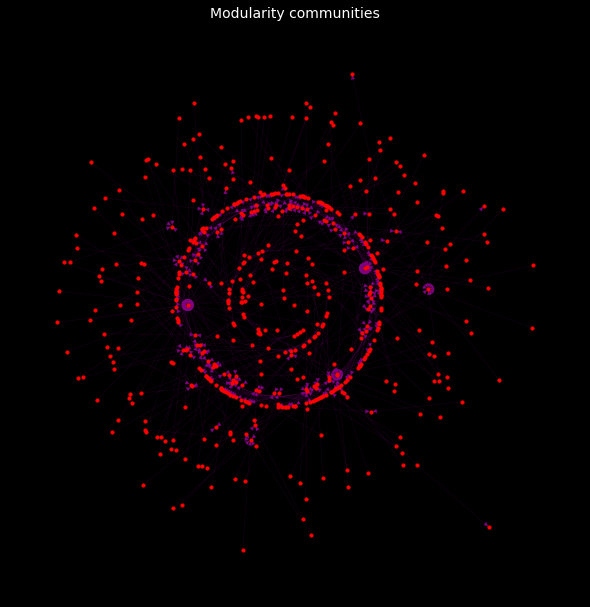

In [71]:
G = nx.read_gpickle(fname_interaction_network)

nv_max = 1000
nv = G.number_of_nodes()

if nv<nv_max:
    pos = nx.kamada_kawai_layout(G.to_undirected())  #position of each node in the network
    fig = plt.figure(figsize=(8,8))
    nx.draw(G, pos, node_color = node_color, 
            width= edge_width, 
            edge_color=edge_color,
            node_size=node_size,
           with_labels=False,
            font_color = 'white')
    fig.set_facecolor(background_color)
    plt.title("Modularity communities",color = 'white',fontsize = 14)
    plt.show()
    
else: print(f"Network has {nv} nodes, which is more than {nv_max}")

### Centrality calculation

We can look at the nodes with the highest network centralities.

In [43]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G)
EC = nx.eigenvector_centrality(G.reverse(),max_iter = 1000)  #reverse edges to match networx convention

dictionary_list = []
for author_id in Din.keys():
    screen_name = G.nodes[author_id]['username']
    row = {'author_id':author_id,
           'screen_name':screen_name,
          'out_degree_centrality':Dout[author_id],
          'closeness_centrality':CC[author_id],
          'betweenness_centrality':BC[author_id],
          'eigenvector_centrality':EC[author_id],
          'in_degree_centrality':Din[author_id]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)
df_centrality.sort_values(by = ['out_degree_centrality'],ascending = False).head()



,author_id,screen_name,out_degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,in_degree_centrality
50,1349149096909668363,POTUS,0.010676,0.010676,0.0,0.272264,0.0
201,18208354,joerogan,0.007117,0.007117,0.0,0.181616,0.0
106,1917731,thehill,0.003559,0.003559,0.0,0.090968,0.0
254,1181006491030974465,Ninnysflowers,0.003559,0.003559,0.0,0.090968,0.0
432,993137216309383169,NathanMackBrown,0.003559,0.003559,0.0,0.090968,0.0


# Build Similarity Network

We can build a similarity network from the interaction network.  In this network there is an edge between a pair of nodes of their similarity exceeds a minimum threshold.  For similarity, we use a measure called the Jaccard Coefficient (https://en.wikipedia.org/wiki/Jaccard_index).  The similarity network is useful for finding communities.

The user inputs are as follows:

1. `fname_interaction_network` = name of the file where you saved the interaction network.  Make sure it ends with `".pickle"`.

2. `fname_similarity_network` = name of the file where you will save the similarity network.  Make sure it ends with `".pickle"`.

3. `ne_max` = the maximum number of edges in the similarity network

4. `jmin` = minimum value of jaccard coefficient of an edge in order to keep it in the similarity network

In [44]:
fname_interaction_network = 'data/lecture_13_interaction_network.pickle'
fname_similarity_network = 'data/lecture_13_similarity_network.pickle'

ne_max = 1e10  #max number of edges in network
jmin = 0.5  #minimum value of jaccard coefficient to keep in network

In [45]:
%%time
G = nx.read_gpickle(fname_interaction_network)

Gsim = nx.Graph()
preds = nx.jaccard_coefficient(G.to_undirected())
ne=0
for c, x in enumerate(preds):
    if x[2]>jmin:
        Gsim.add_edge(x[0],x[1],weight=x[2])
        ne+=1
    if c%1e6==0:
        print(f"node pair {c}, {ne} edges formed in similarity network")
    if ne>ne_max:break

print(f"Similarity network has {Gsim.number_of_nodes()} nodes and {Gsim.number_of_edges()} edges over {c} node pairs")


node pair 0, 0 edges formed in similarity network
Similarity network has 293 nodes and 1662 edges over 157793 node pairs
Wall time: 1.13 s


In [46]:
#save similarity network
nx.write_gpickle(Gsim, fname_similarity_network)


### Find Communities Using Similarity Network

We can find the modularity communities in the similarity network and plot their sizes.

In [49]:
Gsim = nx.read_gpickle(fname_similarity_network)

Comm = nx_comm.greedy_modularity_communities(Gsim.to_undirected())
C = []
V = []
for count,comm in enumerate(Comm):
    for v in comm:
        C.append(count)
        V.append(v)
        
df_mod = pd.DataFrame({'screen_name':V, 'community':C})
ncomm_mod = len(df_mod.community.unique())
print(f"{ncomm_mod} modularity communities")

79 modularity communities


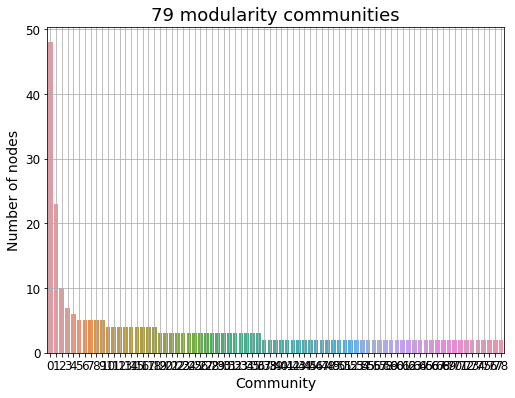

In [52]:
#plot modularity community sizes
fig = plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
ax = sns.countplot(data=df_mod, x="community")
plt.xlabel("Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{ncomm_mod} modularity communities", fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid()

### Draw Similarity Network (If Not Too Big)

In [53]:
Colors = [np.random.uniform(0,1,3) for _ in range(ncomm_mod)]


In [55]:
node_color_mod = [Colors[df_mod.community[df_mod.screen_name==node].values[0]] for node in Gsim.nodes()]



In [56]:
edge_color = 'purple'
background_color = 'black'
edge_width = .1
node_size = 10

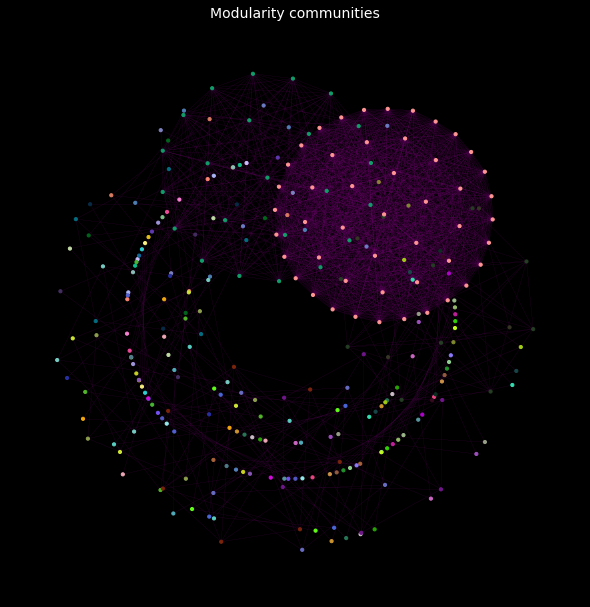

Wall time: 603 ms


In [73]:
%%time
nv_max = 1000
nv = Gsim.number_of_nodes()

if nv<nv_max:
    pos = nx.kamada_kawai_layout(Gsim.to_undirected())  #position of each node in the network
    fig = plt.figure(figsize=(8,8))
    nx.draw(Gsim, pos, node_color = node_color_mod, 
            width= edge_width, 
            edge_color=edge_color,
            node_size=node_size,
           with_labels=False,
            font_color = 'white')
    fig.set_facecolor(background_color)
    plt.title("Modularity communities",color = 'white',fontsize = 14)
    plt.show()
    
else: print(f"Network has {nv} nodes, which is more than {nv_max}")